# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra made up of linear combinations of single iron reference spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
#!pip install git+https://github.com/autonomio/talos@1.0

# Using forked Talos v1.0
#!pip install git+git://github.com/lukaspie/talos.git@1.0#egg=talos 

# =============================================================================
# If forked repo is present on Google Drive.
os.chdir('/content/drive/My Drive/deepxps/talos')
! git checkout 1.0
!pip install .
os.chdir('/content/drive/My Drive/deepxps')
!pwd
# =============================================================================

!pip install python-docx
#!pip install tensorflow==2.5 as tf

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib

# Tensorflow imports
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tf.keras.backend.clear_session()

# Set random seed for reproducible loading
seed = 502
np.random.seed(seed)

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Check TensorFlow and TensorFlow Probability versions

In [3]:
f"TF version: {tf.__version__}."
f"TFP version: {tfp.__version__}."

'TF version: 2.5.0.'

'TFP version: 0.13.0.'

### Check hardware

In [4]:
from tensorflow.python.profiler import profiler_client

try:
    #tf.test.gpu_device_name() == '/device:GPU:0':
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))
except:
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print('Found TPU: {}'.format(profiler_client.monitor(tpu_profile_service_address, 100, 2)))

Found GPU: /device:GPU:0


## Initial training

### Load custom modules

In [29]:
try:
    importlib.reload(classifier)
    importlib.reload(opt)
    importlib.reload(clfutils)
    print('Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.optimization as opt
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

<module 'xpsdeeplearning.network.classifier' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/classifier.py'>

<module 'xpsdeeplearning.network.optimization' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/optimization.py'>

<module 'xpsdeeplearning.network.utils' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/utils.py'>

Modules were reloaded.


### Set up the parameters & folder structure



In [30]:
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = 'Ni_2_classes_long_linear_comb_small_gas_phase_bayesian_classification_optimization'

hyperopt = opt.Hyperoptimization(time=time,
                                 exp_name=exp_name)
hyperopt.initialize_clf(task="classification",
                        intensity_only=False)

### If labels not saved with data ###
# =============================================================================
# labels = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']
# hyperopt.clf = classifier.Classifier(time = time,
#                            exp_name = exp_name,
#                            task = 'regression',
#                            intensity_only = True,
#                            labels = labels)
# =============================================================================

Test folder created at /runs/20210713_16h31m_Ni_2_classes_long_linear_comb_small_gas_phase_bayesian_classification_optimization/param_tests
Model folder created at /20210713_16h31m_Ni_2_classes_long_linear_comb_small_gas_phase_bayesian_classification_optimization/model
Logs folder created at /20210713_16h31m_Ni_2_classes_long_linear_comb_small_gas_phase_bayesian_classification_optimization/logs
Figures folder created at /20210713_16h31m_Ni_2_classes_long_linear_comb_small_gas_phase_bayesian_classification_optimization/figures


### Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 501 features (X) + 2 labels (y)


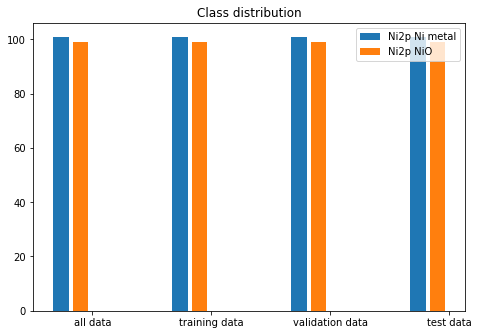

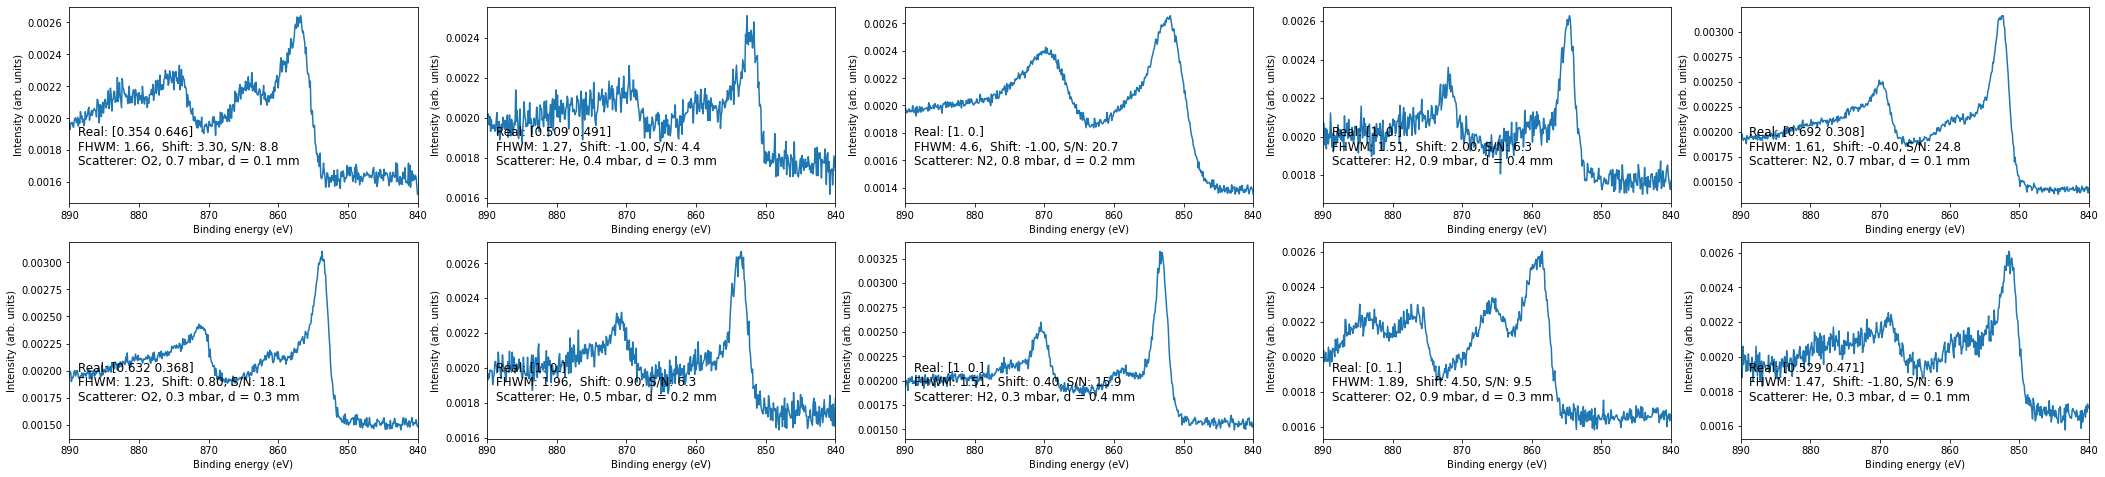

In [31]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210528_Ni_linear_combination_small_gas_phase.h5'

train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000#0#200000

X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        hyperopt.clf.load_data_preprocess(input_filepath = input_filepath,
                                          no_of_examples = no_of_examples,
                                          train_test_split = train_test_split,
                                          train_val_split = train_val_split)
               
# Check how the examples are distributed across the classes.
class_distribution = hyperopt.clf.datahandler.check_class_distribution(hyperopt.clf.task)
hyperopt.clf.plot_class_distribution()
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train')

Remaining no. of training examples: 30
Remaining no. of val examples: 5
Remaining no. of test examples: 5


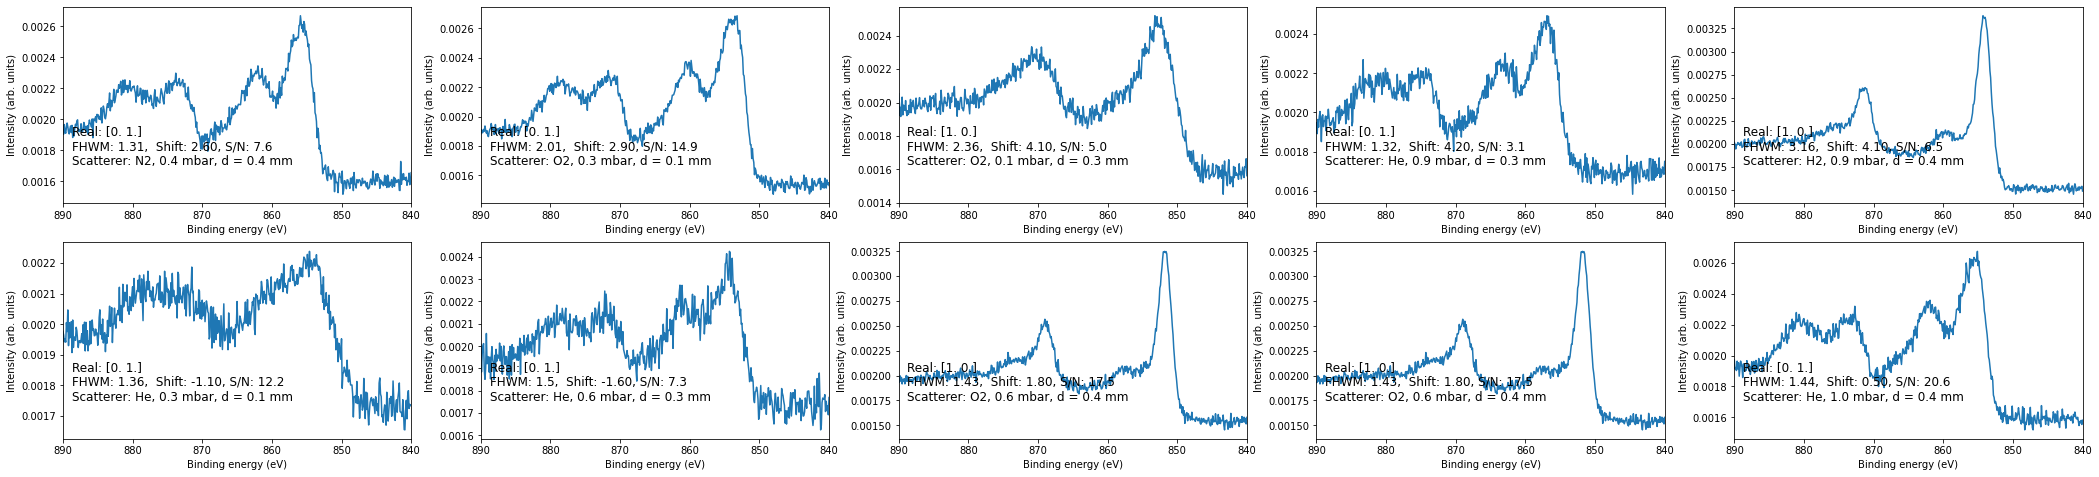

In [32]:
### Only use classification data
if hyperopt.clf.task == "classification":
    indices_train = np.where(hyperopt.clf.datahandler.y_train == 0.0)[0]
    indices_val = np.where(hyperopt.clf.datahandler.y_val == 0.0)[0]
    indices_test= np.where(hyperopt.clf.datahandler.y_test == 0.0)[0]

    X_train, y_train = hyperopt.clf.datahandler.X_train[indices_train], hyperopt.clf.datahandler.y_train[indices_train]
    X_val, y_val = hyperopt.clf.datahandler.X_val[indices_val], hyperopt.clf.datahandler.y_val[indices_val]
    X_test, y_test = hyperopt.clf.datahandler.X_test[indices_test], hyperopt.clf.datahandler.y_test[indices_test]

    hyperopt.clf.datahandler.X_train, hyperopt.clf.datahandler.y_train = X_train, y_train
    hyperopt.clf.datahandler.X_val, hyperopt.clf.datahandler.y_val = X_val, y_val 
    hyperopt.clf.datahandler.X_test, hyperopt.clf.datahandler.y_test = X_test, y_test

    #hyperopt.clf.datahandler.y_train[0:5]
    #hyperopt.clf.datahandler.y_val[0:5]
    #hyperopt.clf.datahandler.y_test[0:5]

    num_train = 30
    num_val = 5
    num_test = 5

    hyperopt.clf.datahandler.X_train, hyperopt.clf.datahandler.y_train = hyperopt.clf.datahandler.X_train[0:num_train], hyperopt.clf.datahandler.y_train[0:num_train]
    hyperopt.clf.datahandler.X_val, hyperopt.clf.datahandler.y_val = hyperopt.clf.datahandler.X_train[0:num_val], hyperopt.clf.datahandler.y_train[0:num_val]
    hyperopt.clf.datahandler.X_test, hyperopt.clf.datahandler.y_test = hyperopt.clf.datahandler.X_train[0:num_test], hyperopt.clf.datahandler.y_train[0:num_test]
    hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train')  

    print(f"Remaining no. of training examples: {hyperopt.clf.datahandler.y_train.shape[0]}")
    print(f"Remaining no. of val examples: {hyperopt.clf.datahandler.y_val.shape[0]}")
    print(f"Remaining no. of test examples: {hyperopt.clf.datahandler.y_test.shape[0]}")

### Design the model

In [33]:
try:
    importlib.reload(models)
    print('Models module was reloaded.')
except:
    import xpsdeeplearning.network.models as models
    print('Models module was loaded.')

<module 'xpsdeeplearning.network.models' from '/content/drive/My Drive/deepxps/xpsdeeplearning/network/models.py'>

Models module was reloaded.


In [35]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

init_params = {"conv_layer" : tfp.layers.Convolution1DFlipout,
               "dense_layer" : tfp.layers.DenseFlipout,
               "flatten_layer" : layers.GlobalMaxPooling1D(name="gmax_pool_1"),
               "output_dist" : False,
               "kl_divergence_fn": (lambda q, p, _: (tfp.distributions.kl_divergence(q, p) /
                                                     tf.cast(hyperopt.clf.datahandler.X_train.shape[0], dtype=tf.float32)))
              }

In [36]:
class ProbabilisticClassificationCNNTalos(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    This is to be used for classification -> softmax activation in the
    last layer.
    """

    def __init__(self,
                 inputshape, 
                 num_classes,
                 params):

        self.input_1 = layers.Input(shape=inputshape)

        self.conv_1_short = params["conv_layer"](
            filters=4,
            kernel_size=5,
            strides=1,
            padding="same",
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"],
            activation="relu",
            name="conv_1_short",
        )(self.input_1)
        self.conv_1_medium = params["conv_layer"](
            filters=4,
            kernel_size=10,
            strides=1,
            padding="same",
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"],
            activation="relu",
            name="conv_1_medium",
        )(self.input_1)
        self.conv_1_long = params["conv_layer"](
            filters=4,
            kernel_size=15,
            strides=1,
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"],
            padding="same",
            activation="relu",
            name="conv_1_long",
        )(self.input_1)

        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        no_of_inputs = len(sublayers)
        merged_sublayers = layers.concatenate(sublayers, 
                                              name="contanete_1")

        self.conv_2 = params["conv_layer"](
            filters=4,
            kernel_size=10,
            strides=1,
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"],
            padding="valid",
            activation="relu",
            name="conv_2",
        )(merged_sublayers)
        self.conv_3 = params["conv_layer"](
            filters=10,
            kernel_size=10,
            strides=1,
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"],
            padding="valid",
            activation="relu",
            name="conv_3",
        )(self.conv_2)
        #self.average_pool_1 = layers.AveragePooling1D(name="average_pool_1")(
        #    self.conv_3
        #)
        self.flatten_pool_1 = params["flatten_layer"](self.conv_3)

        self.drop_1 = layers.Dropout(rate=0.2, name="drop_1")(self.flatten_pool_1)
        self.dense_1 = params["dense_layer"](
            units=1000,
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"], 
            activation="relu",
            name="dense_1"
        )(self.drop_1)
        self.dense_2 = params["dense_layer"](
            units=num_classes,
            kernel_divergence_fn=params["kl_divergence_fn"],
            bias_divergence_fn=params["kl_divergence_fn"], 
            activation="softmax", 
            name="dense_2"
        )(self.dense_1)
        
        if params["output_dist"]:
            self.outputs = tfp.layers.DistributionLambda(
                make_distribution_fn=lambda x: tfd.Independent(
                    distribution=tfd.Normal(
                        loc=[0,2], 
                        scale=1e-3 + tf.math.softplus(0.05 * x[:,1:2])
                        ),
                    reinterpreted_batch_ndims=2)
            )(self.dense_1)
       
        else:
            self.outputs = self.dense_2

        super(ProbabilisticClassificationCNNTalos, self).__init__(
            inputs=self.input_1,
            outputs=self.outputs,
            inputshape=inputshape,
            num_classes=num_classes,
            no_of_inputs=no_of_inputs,
            name="ProbabilisticClassificationCNNTalos",
        )

#### Not used

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class ProbabilityCNNTest(models.EmptyModel):
    """
    
    This is to be used for regression on all labels. -> sigmoid 
    activation in the last layer.
    """
    def __init__(self, inputshape, num_classes, kl_divergence_function):   
        self.input_1 = layers.Input(shape = inputshape)
        self.conv_1 = tfp.layers.Convolution1DFlipout(
            filters=16,
            kernel_size=5,
            strides=1,
            padding="same", 
            activation="relu",
            name="conv_1", 
            kernel_divergence_fn=kl_divergence_function)(self.input_1)
        self.mp_1 = layers.MaxPool1D(
            strides=2, 
            pool_size=2, 
            padding="same")(self.conv_1)
        self.conv_2 = tfp.layers.Convolution1DFlipout(
            filters=16,
            kernel_size=5, 
            strides=1,
            data_format="channels_last", 
            padding="same",
            activation="relu", 
            name="conv_2",
            kernel_divergence_fn=kl_divergence_function)(self.mp_1)
        self.mp_2 = layers.MaxPool1D(
            strides=2, 
            pool_size=2, 
            padding="same")(self.conv_2)
        self.flatten = layers.Flatten()(self.mp_2)
        self.dense_1 = tfp.layers.DenseFlipout(
            units=num_classes,
            activation='sigmoid',
            kernel_divergence_fn=kl_divergence_function)(self.flatten)
        self.output_norm = layers.Lambda(
            lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
            name = 'output_normalization')(self.dense_1)

        no_of_inputs = 1

        super(ProbabilityCNNTest, self).__init__(inputs=self.input_1,
                                                 outputs=self.output_norm,
                                                 inputshape=inputshape,
                                                 num_classes=num_classes,
                                                 no_of_inputs=no_of_inputs,
                                                 name='ProbabilityCNNTest')

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.python.keras import backend as K

class ProbabilityCNN(models.EmptyModel):
    """
    A CNN with three convolutional layers of different kernel size at 
    the beginning. Works well for learning across scales.
    
    This is to be used for regression on all labels. -> sigmoid 
    activation in the last layer.
    """
    def __init__(self, 
                 inputshape,
                 num_classes,
                 kl_divergence_function,
                 task):
        self.input_1 = layers.Input(shape = inputshape)
                
        self.conv_1_short = tfp.layers.Convolution1DFlipout(
            filters=12,
            kernel_size=5,
            strides=1,
            padding='same',
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation='relu',
            name='conv_1_short')(self.input_1)
        self.conv_1_medium = tfp.layers.Convolution1DFlipout(
            filters=12,
            kernel_size=10,
            strides=1,
            padding='same',
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation='relu',
            name='conv_1_medium')(self.input_1)
        self.conv_1_long = tfp.layers.Convolution1DFlipout(
            filters=12,
            kernel_size=15,
            strides=1,
            padding='same',
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation='relu',
            name='conv_1_long')(self.input_1)
        
        sublayers = [self.conv_1_short, self.conv_1_medium, self.conv_1_long]
        merged_sublayers = layers.concatenate(sublayers)

        self.conv_2 = tfp.layers.Convolution1DFlipout(
            filters=10,
            kernel_size=5,
            strides=1,
            padding='valid',
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation='relu',
            name='conv_2')(merged_sublayers)
        self.conv_3 = tfp.layers.Convolution1DFlipout(
            filters=10,
            kernel_size=5,
            strides=1,
            padding='valid',
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation='relu',
            name="conv_3")(self.conv_2)
        self.average_pool_1 = layers.AveragePooling1D(
            name='average_pool_1')(self.conv_3)
        
        self.flatten_1 = layers.Flatten(name='flatten1')(self.average_pool_1)
        #self.drop_1 = layers.Dropout(rate=0.2,
        #                             name='drop_1')(self.flatten_1)
        self.dense_1 = tfp.layers.DenseFlipout(
            units=4000,
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation='relu',
            name='dense_1')(self.flatten_1)
        
        if task == "regression":
            dense_act = "sigmoid"
        elif task == "classification":
             dense_act = "softmax"  
                    
        self.dense_2 = tfp.layers.DenseFlipout(
            units=num_classes,
            kernel_divergence_fn=kl_divergence_function,
            bias_divergence_fn=kl_divergence_function,
            activation=dense_act,
            name='dense_2')(self.dense_1)
        
        #self.output_norm = layers.Lambda(
        #    lambda x: x/tf.reshape(K.sum(x, axis=-1),(-1,1)),
        #    name = 'output_normalization')(self.dense_2)

        no_of_inputs = len(sublayers)

        super(ProbabilityCNN, self).__init__(inputs=self.input_1,
                                             outputs=self.dense_2,
                                             inputshape=inputshape,
                                             num_classes=num_classes,
                                             no_of_inputs=no_of_inputs,
                                             name='ProbabilityCNN')

#### Build the model

In [37]:
hyperopt.clf.model = ProbabilisticClassificationCNNTalos(hyperopt.clf.datahandler.input_shape,
                                                         hyperopt.clf.datahandler.num_classes,
                                                         init_params)

### Compile and summarize the model

Model: "ProbabilisticClassificationCNNTalos"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 501, 2)]     0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1DFlipout)    (None, 501, 4)       84          input_3[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1DFlipout)   (None, 501, 4)       164         input_3[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1DFlipout)     (None, 501, 4)       244         input_3[0][0]                    
________________________________________________________________

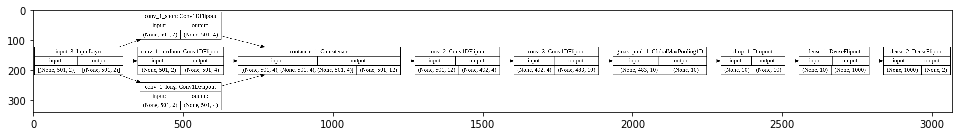

In [38]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.losses import CategoricalCrossentropy

init_params["learning_rate"] = 1e-04
init_params["optimizer"] = Adam
optimizer = init_params["optimizer"](init_params["learning_rate"])

if hyperopt.clf.task == "regression":
    mae = MeanAbsoluteError
    mse = MeanSquaredError
    init_params["loss_function"] = mse

    hyperopt.clf.model.compile(loss = init_params["loss_function"](),
                      optimizer = optimizer,
                      metrics=["mse"])
    # =============================================================================
    # mse = MeanSquaredError()
    # hyperopt.clf.model.compile(loss = mse, optimizer = optimizer)
    # =============================================================================
    
elif hyperopt.clf.task == "classification":
    init_params["loss_function"] = CategoricalCrossentropy
    
    hyperopt.clf.model.compile(loss = ["loss_function"],
                               optimizer = optimizer,
                               metrics = ["accuracy",
                                          "categorical_crossentropy"])

# Plot summary and save model plot.
hyperopt.clf.summary()
hyperopt.clf.save_and_print_model_image()

In [39]:
test_params = {"epochs" : [100],
               "batch_size" : [32],
               "learning_rate" : [init_params["learning_rate"]],
               "optimizer" : [init_params["optimizer"]],
               "loss_function" : [init_params["loss_function"]],  
               "conv_layer" : [tfp.layers.Convolution1DFlipout,
                               tfp.layers.Convolution1DReparameterization],
               "dense_layer" : [tfp.layers.DenseFlipout,
                                tfp.layers.DenseLocalReparameterization,
                                tfp.layers.DenseReparameterization],
               "flatten_layer" : [layers.GlobalMaxPooling1D(name="gmax_pool_1"),
                                  layers.Flatten(name="flatten1")],
               "output_dist" : [True, False],
               "kl_divergence_fn": [(lambda q, p, _: (tfp.distributions.kl_divergence(q, p) /
                                                     tf.cast(hyperopt.clf.datahandler.X_train.shape[0], dtype=tf.float32)))]
              }
        

In [40]:
# RANDOMNESS ARGUMENTS
random_method = "quantum"

# LIMITER ARGUMENTS
performance_target = None #None or list [metric, threshold, loss or not] 
fraction_limit = None #float
round_limit = None #int
time_limit = None #'2021-02-25 18:00' #Format "%Y-%m-%d %H:%M". CET -4

# OPTIMIZER ARGUMENTS
reduction_method = "correlation"
reduction_interval = 30
reduction_window = 20
reduction_threshold = 0.2

hyperopt.scan_parameter_space(test_params,
                              random_method = random_method,
                              seed = seed, 
                              performance_target = performance_target,
                              fraction_limit = fraction_limit,
                              round_limit = round_limit,
                              time_limit = time_limit,
                              reduction_method = reduction_method,
                              reduction_interval = reduction_interval,
                              reduction_window = reduction_window,
                              reduction_threshold = reduction_threshold)

  0%|          | 0/24 [00:00<?, ?it/s]

{'batch_size': 32, 'conv_layer': <class 'tensorflow_probability.python.layers.conv_variational.Conv1DFlipout'>, 'dense_layer': <class 'tensorflow_probability.python.layers.dense_variational.DenseFlipout'>, 'epochs': 100, 'flatten_layer': <tensorflow.python.keras.layers.pooling.GlobalMaxPooling1D object at 0x7fe7d35f4f10>, 'kl_divergence_fn': <function <lambda> at 0x7fe7dba28f80>, 'learning_rate': 0.0001, 'loss_function': <class 'tensorflow.python.keras.losses.CategoricalCrossentropy'>, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'output_dist': True}


TypeError: ignored

In [89]:
r = hyperopt.scans[0].result
for l in r:
  for x in l:
    try:
      if issubclass(x,
                  tf.keras.layers.Layer):
        print(x)
    except TypeError:
      if issubclass(type(x),
                  tf.keras.layers.Layer):
        print("type", x)

<class 'tensorflow_probability.python.layers.conv_variational.Conv1DFlipout'>
<class 'tensorflow_probability.python.layers.dense_variational.DenseFlipout'>
type <tensorflow.python.keras.layers.pooling.GlobalMaxPooling1D object at 0x7fe7d35f4f10>


### Analysis of scan results

In [45]:
hyperopt.initialize_analyzer()

# Show the df with the best parameters highlighted.
def _highlight_best(row):
    if row['val_loss'] == hyperopt.analyzer._minimum_value('val_loss'):
        return ['background-color: yellow']*hyperopt.analyzer.df.shape[1]
    else:
        return ['background-color: white']*hyperopt.analyzer.df.shape[1]
    
hyperopt.analyzer.df.style.apply(_highlight_best, axis=1)

#### Line plot of a chosen metric

In [ ]:
line_data = hyperopt.analyzer.create_line_data(metric = 'val_loss')
line_plot = opt.LinePlot(line_data)
line_plot.plot() 
line_plot.to_file(hyperopt.fig_dir)

#### Histogram of a metric across all rounds

In [ ]:
hist_data = hyperopt.analyzer.create_hist_data(metric = 'val_loss')
hist_plot = opt.HistPlot(hist_data)
hist_plot.plot() 
hist_plot.to_file(hyperopt.fig_dir)

#### Correlation matrix

In [ ]:
corr_data = hyperopt.analyzer.correlate(metric = 'val_loss')
corr_plot = opt.CorrPlot(corr_data)
corr_plot.plot() 
corr_plot.to_file(hyperopt.fig_dir)

#### Kernel density estimator plot for one metric

In [ ]:
x_kde_1 = 'val_loss'

kde_data_1 = hyperopt.analyzer.create_kde_data(x_kde_1)
kde_plot_1 = opt.KDEPlot(data = kde_data_1,
                         x = x_kde_1)
kde_plot_1.plot()
kde_plot_1.to_file(hyperopt.fig_dir)

#### Kernel density estimator plot for two metrics

In [ ]:
x_kde_2 = 'val_loss'
y_kde_2 = 'loss'

kde_data_2 = hyperopt.analyzer.create_kde_data(x_kde_2,y_kde_2)
kde_plot_2 = opt.KDEPlot(data = kde_data_2,
                              x = x_kde_2,
                              y = y_kde_2)
kde_plot_2.plot()
kde_plot_2.to_file(hyperopt.fig_dir)

#### Bar plot with four parameters

In [ ]:
x_bar = 'learning_rate'
y_bar = 'val_loss'
hue_bar = 'conv_3_filters'
col_bar = 'dense_1_units'

#drop_1_rate, , conv_3_kernel_size, dense_1_units

bar_data = hyperopt.analyzer.create_bar_data(x_bar, y_bar, hue_bar, col_bar)
bar_plot = opt.BarPlot(bar_data,
                       x_bar,
                       y_bar,
                       hue_bar,
                       col_bar)
bar_plot.plot()
bar_plot.to_file(hyperopt.fig_dir)

## Training and testing of best model from parameter space

### Load the model with the best performance

In [ ]:
metric = 'val_loss'
best_params = hyperopt.get_best_params(metric = metric)
hyperopt.load_model_from_scans(best = True, metric = metric)
# Plot summary and save model plot.
hyperopt.clf.summary()

In [ ]:
hyperopt.clf.datahandler.batch_size = hyperopt.best_params['batch_size']
hyperopt.clf.datahandler.epochs = hyperopt.best_params['epochs']

### Train with best parameters

In [ ]:
epochs = 25 #hyperopt.best_params['epochs']
batch_size = int(hyperopt.best_params['batch_size'])

hist = hyperopt.clf.train(checkpoint = True,
                          early_stopping = False,
                          tb_log = True, 
                          csv_log = True,
                          hyperparam_log = True,
                          epochs = epochs, 
                          batch_size = batch_size,
                          verbose = 1)

### Plot loss after training

In [ ]:
graph = clfutils.TrainingGraphs(hyperopt.clf.logging.history, 
                                hyperopt.clf.logging.fig_dir)
graph.plot_loss(to_file=True)

### Evaluate on test data

In [ ]:
test_loss = hyperopt.clf.evaluate()
print('Test loss: ' + str(test_loss))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = hyperopt.clf.predict()

###  Save the best model

In [ ]:
#hyperopt.clf.save_model()
hyperopt.clf.pickle_results()

### Show some predictions

#### 10 random training samples

In [ ]:
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show initial predictions

In [ ]:
pred_train_initial, pred_test_initial = hyperopt.clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_initial[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_initial[i]))

In [ ]:
start = 0
stop = 5
no_of_predictions = 100

test_predictions = np.array([hyperopt.clf.model.predict(hyperopt.clf.datahandler.X_test[start:stop]) for i in range(no_of_predictions)]).transpose(1, 0, 2)

for pred in test_predictions:
    print(f"Ground truth: {np.round(y_test[i],3)},",
          f"Mean prediction: {np.mean(pred, axis = 0)} +/- {np.std(pred, axis = 0)}")

### Train

In [ ]:
epochs = 10000
batch_size = 32

hist = hyperopt.clf.train(checkpoint = False,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

sound = False
if sound:
    from google.colab import output
    output.eval_js('new Audio("http://soundbible.com/grab.php?id=1795&type=mp3").play()')

### Plot loss

In [ ]:
graph = hyperopt.clfutils.TrainingGraphs(hyperopt.clf.logging.history, hyperopt.clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if hyperopt.clf.task == 'classification':
    graph.plot_accuracy(to_file = False)

### Evaluate on test data

In [ ]:
if hyperopt.clf.task == 'classification':
    score = hyperopt.clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif hyperopt.clf.task == 'regression':
    test_loss = hyperopt.clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = hyperopt.clf.predict()
if hyperopt.clf.task == 'classification':
    pred_train_classes, pred_test_classes = hyperopt.clf.predict_classes()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test[i]))

In [ ]:
start = 0
stop = 5
no_of_predictions = 100

test_predictions = np.array([hyperopt.clf.model.predict(hyperopt.clf.datahandler.X_test[start:stop]) for i in range(no_of_predictions)]).transpose(1, 0, 2)

for pred in test_predictions:
    print(f"Ground truth: {np.round(y_test[i],3)},",
          f"Mean prediction: {np.mean(pred, axis = 0)} +/- {np.std(pred, axis = 0)}")

###  Histogram of predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = iter(mcolors.TABLEAU_COLORS.keys())

for pred in test_predictions:
    c = next(colors)
    for i in range(pred.shape[1]):
      _ = plt.hist(pred[:,i], 
                   color=c,
                   bins = 5,
                   alpha=0.4,
                   histtype='step',
                   fill=True,
                   linewidth=4,
                   density=True)

_ = plt.xlabel('Predicted Labels (%)')
_ = plt.ylabel("Density")

legend = [item for item in np.round(hyperopt.clf.datahandler.y_test[start:stop],2) for i in range(2)]
_ = plt.legend(legend)

### Show some predictions

#### 10 random training samples

In [ ]:
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if hyperopt.clf.task == 'classification':
    hyperopt.clf.show_wrong_classification()
elif hyperopt.clf.task == 'regression':
    hyperopt.clf.show_worst_predictions(no_of_spectra = 20)  

### Show posterior weight distribution

In [ ]:
def plot_weight_posteriors(names, qm_vals, qs_vals, fname):
  """Save a PNG plot with histograms of weight means and stddevs.
  Args:
    names: A Python `iterable` of `str` variable names.
      qm_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior means of weight varibles.
    qs_vals: A Python `iterable`, the same length as `names`,
      whose elements are Numpy `array`s, of any shape, containing
      posterior standard deviations of weight varibles.
    fname: Python `str` filename to save the plot to.
  """
  fig = figure.Figure(figsize=(6, 3))
  canvas = backend_agg.FigureCanvasAgg(fig)

  ax = fig.add_subplot(1, 2, 1)
  for n, qm in zip(names, qm_vals):
    sns.distplot(tf.reshape(qm, shape=[-1]), ax=ax, label=n)
  ax.set_title('weight means')
  ax.set_xlim([-1.5, 1.5])
  ax.legend()

  ax = fig.add_subplot(1, 2, 2)
  for n, qs in zip(names, qs_vals):
    sns.distplot(tf.reshape(qs, shape=[-1]), ax=ax)
  ax.set_title('weight stddevs')
  ax.set_xlim([0, 1.])

  fig.tight_layout()
  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))


def plot_heldout_prediction(input_vals, probs,
                            fname, n=10, title=''):
  """Save a PNG plot visualizing posterior uncertainty on heldout data.
  Args:
    input_vals: A `float`-like Numpy `array` of shape
      `[num_heldout] + IMAGE_SHAPE`, containing heldout input images.
    probs: A `float`-like Numpy array of shape `[num_monte_carlo,
      num_heldout, num_classes]` containing Monte Carlo samples of
      class probabilities for each heldout sample.
    fname: Python `str` filename to save the plot to.
    n: Python `int` number of datapoints to vizualize.
    title: Python `str` title for the plot.
  """
  fig = figure.Figure(figsize=(9, 3*n))
  canvas = backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation='None')

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title('posterior samples')

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), tf.reduce_mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('predictive probs')
  fig.suptitle(title)
  fig.tight_layout()

  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))


### Save model and results

In [ ]:
#hyperopt.clf.save_model()
hyperopt.clf.pickle_results()

### Generate report

In [ ]:
dir_name = hyperopt.clf.time + '_' + hyperopt.clf.exp_name
rep = hyperopt.clfutils.Report(dir_name)  
rep.write()

## Continue training

### Load custom modules

In [ ]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(hyperopt.clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as hyperopt.clfutils
    print('\n Modules were loaded.')

### Reload classifier from previous run

In [ ]:
runpath = r"/content/drive/My Drive/deepxps/runs/20210707_19h00m_Ni_2_classes_long_linear_comb_small_gas_phase_no_bayesian_classification"
hyperopt.clf = classifier.restore_hyperopt.clf_from_logs(runpath)

### Load and inspect the data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test,\
    aug_values_train, aug_values_val, aug_values_test =\
        hyperopt.clf.load_data_preprocess(input_filepath = hyperopt.clf.logging.hyperparams['input_filepath'],
                                 no_of_examples = hyperopt.clf.logging.hyperparams['no_of_examples'],
                                 train_test_split = hyperopt.clf.logging.hyperparams['train_test_split'],
                                 train_val_split = hyperopt.clf.logging.hyperparams['train_val_split'])
                
# Check how the examples are distributed across the classes.
class_distribution = hyperopt.clf.datahandler.check_class_distribution(hyperopt.clf.task)
hyperopt.clf.plot_class_distribution()
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train')  

In [ ]:
### Only use classification data
indices_train = np.where(hyperopt.clf.datahandler.y_train == 0.0)[0]
indices_val = np.where(hyperopt.clf.datahandler.y_val == 0.0)[0]
indices_test= np.where(hyperopt.clf.datahandler.y_test == 0.0)[0]

X_train, y_train = hyperopt.clf.datahandler.X_train[indices_train], hyperopt.clf.datahandler.y_train[indices_train]
X_val, y_val = hyperopt.clf.datahandler.X_val[indices_val], hyperopt.clf.datahandler.y_val[indices_val]
X_test, y_test = hyperopt.clf.datahandler.X_test[indices_test], hyperopt.clf.datahandler.y_test[indices_test]

hyperopt.clf.datahandler.X_train, hyperopt.clf.datahandler.y_train = X_train, y_train
hyperopt.clf.datahandler.X_val, hyperopt.clf.datahandler.y_val = X_val, y_val 
hyperopt.clf.datahandler.X_test, hyperopt.clf.datahandler.y_test = X_test, y_test

hyperopt.clf.datahandler.y_train
hyperopt.clf.datahandler.y_val
hyperopt.clf.datahandler.y_test
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train')  

### Load the model

In [ ]:
hyperopt.clf.load_model(compile_model = True)

### Summarize the model

In [ ]:
# Plot summary and save model plot.
hyperopt.clf.summary()
hyperopt.clf.save_and_print_model_image()

### Show predictions with current model

In [ ]:
start = 0
stop = 5
no_of_predictions = 100

test_predictions = np.array([hyperopt.clf.model.predict(hyperopt.clf.datahandler.X_test[start:stop]) for i in range(no_of_predictions)]).transpose(1, 0, 2)

for pred in test_predictions:
    print(f"Ground truth: {np.round(y_test[i],3)},",
          f"Mean prediction: {np.mean(pred, axis = 0)} +/- {np.std(pred, axis = 0)}")

###  Histogram of predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = iter(mcolors.TABLEAU_COLORS.keys())

for pred in test_predictions:
    c = next(colors)
    for i in range(pred.shape[1]):
      _ = plt.hist(pred[:,i],
                   color=c,
                   bins = 125,
                   alpha=0.4,
                   histtype='step',
                   fill=True,
                   linewidth=4,
                   density=True)

_ = plt.xlabel('Predicted Labels (%)')
_ = plt.ylabel("Density")
legend = [item for item in np.round(hyperopt.clf.datahandler.y_test[start:stop],2) for i in range(2)]
_ = plt.legend(legend)

### Train

In [ ]:
epochs = 500

new_learning_rate = 1e-04#5e-06

hist = hyperopt.clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = hyperopt.clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = hyperopt.clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

In [ ]:
start = 0
stop = 5
no_of_predictions = 100

test_predictions = np.array([hyperopt.clf.model.predict(hyperopt.clf.datahandler.X_test[start:stop]) for i in range(no_of_predictions)]).transpose(1, 0, 2)

for pred in test_predictions:
    print(f"Ground truth: {np.round(y_test[i],3)},",
          f"Mean prediction: {np.mean(pred, axis = 0)} +/- {np.std(pred, axis = 0)}")

### Train

In [ ]:
epochs = 1000

new_learning_rate = 1e-05#5e-06

hist = hyperopt.clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = hyperopt.clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Show predictions with current model

In [ ]:
pred_train_intermediate, pred_test_intermediate = hyperopt.clf.predict()

print('Train:')
for i in range(5):
    print('real: ' + str(np.round(y_train[i],3)),
          'pred: ' + str(pred_train_intermediate[i]))
print('Test:')
for i in range(5):
    print('real: ' + str(np.round(y_test[i],3)),
          'pred: ' + str(pred_test_intermediate[i]))

In [ ]:
start = 0
stop = 5
no_of_predictions = 100

test_predictions = np.array([hyperopt.clf.model.predict(hyperopt.clf.datahandler.X_test[start:stop]) for i in range(no_of_predictions)]).transpose(1, 0, 2)

for pred in test_predictions:
    print(f"Ground truth: {np.round(y_test[i],3)},",
          f"Mean prediction: {np.mean(pred, axis = 0)} +/- {np.std(pred, axis = 0)}")

### Train

In [ ]:
epochs = 1000

new_learning_rate = 1e-05#5e-06

hist = hyperopt.clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 hyperparam_log = True,
                 epochs = epochs, 
                 batch_size = hyperopt.clf.logging.hyperparams['batch_size'],
                 verbose = 1,)
#                 new_learning_rate = new_learning_rate)

### Plot loss

In [ ]:
graph = hyperopt.clfutils.TrainingGraphs(hyperopt.clf.logging.history, hyperopt.clf.logging.fig_dir)
graph.plot_loss(to_file = True)
if hyperopt.clf.task == 'classification':
    graph.plot_accuracy(to_file = True)

### Evaluate on test data

In [ ]:
if hyperopt.clf.task == 'classification':
    score = hyperopt.clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif hyperopt.clf.task == 'regression':
    test_loss = hyperopt.clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

###  Predict on train and test data

In [ ]:
pred_train, pred_test = hyperopt.clf.predict()
if hyperopt.clf.task == 'classification':
    pred_train_classes, pred_test_classes = hyperopt.clf.predict_classes()

In [ ]:
start = 0
stop = 5
no_of_predictions = 100

test_predictions = np.array([hyperopt.clf.model.predict(hyperopt.clf.datahandler.X_test[start:stop]) for i in range(no_of_predictions)]).transpose(1, 0, 2)

for pred in test_predictions:
    print(f"Ground truth: {np.round(y_test[i],3)},",
          f"Mean prediction: {np.mean(pred, axis = 0)} +/- {np.std(pred, axis = 0)}")

###  Histogram of predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = iter(mcolors.TABLEAU_COLORS.keys())

for pred in test_predictions:
    c = next(colors)
    for i in range(pred.shape[1]):
      _ = plt.hist(pred[:,i],
                   color=c,
                   bins = 125,
                   alpha=0.4,
                   histtype='step',
                   fill=True,
                   linewidth=4,
                   density=True)

_ = plt.xlabel('Predicted Labels (%)')
_ = plt.ylabel("Density")
legend = [item for item in np.round(hyperopt.clf.datahandler.y_test[start:stop],2) for i in range(2)]
_ = plt.legend(legend)

### Show some predictions

#### 10 random training samples

In [ ]:
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'train', with_prediction = True)  

#### 10 random test samples

In [ ]:
hyperopt.clf.plot_random(no_of_spectra = 10, dataset = 'test', with_prediction = True)  

### Show wrong/worst predictions

In [ ]:
if hyperopt.clf.task == 'classification':
    hyperopt.clf.show_wrong_classification()
elif hyperopt.clf.task == 'regression':
    hyperopt.clf.show_worst_predictions(no_of_spectra = 20)  

### Save model and data

In [ ]:
#hyperopt.clf.save_model()
hyperopt.clf.pickle_results()

### Generate report

In [ ]:
dir_name = hyperopt.clf.time + '_' + hyperopt.clf.exp_name
rep = hyperopt.clfutils.Report(dir_name)  
rep.write()

## Prepare website upload

In [ ]:
from xpsdeeplearning.network.prepare_upload import Uploader

dataset_path = hyperopt.clf.logging.hyperparams["input_filepath"].rsplit(".",1)[0] + "_metadata.json"
uploader = Uploader(hyperopt.clf.logging.root_dir, dataset_path)
uploader.prepare_upload_params()
uploader.save_upload_params()

## Save output of notebook

In [ ]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/optimization_prob.ipynb'
output_file = os.path.join(hyperopt.clf.logging.log_dir,'optimization_prob_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')